# ***Classificação de Mensagens com o Algoritmo Naive Bayes***

Neste projeto, vamos construir um classificador de filtro de spam para mensagens SMS usando um algoritmo de Naive Bayes. Nosso objetivo é escrever um programa que classifique novas mensagens com acurácia maior que 80% (esperamos que mais que 80% das novas mensagens serão classificadas corretamente como spam ou não spam). Para treinar o algoritmo, usaremos um dataset de 5573 mensagens que já foram classifcadas por humanos. (https://archive.ics.uci.edu/dataset/228/sms+spam+collection)

## 🧠 Naive Bayes para Filtragem de Spam

O algoritmo Naive Bayes é um classificador probabilístico baseado no Teorema de Bayes, que assume que as variáveis (no nosso caso, as palavras das mensagens) são independentes entre si.  
Apesar dessa suposição ser simplificadora (“naive”), o método costuma ter ótimo desempenho em tarefas de classificação de texto, como a detecção de spam.

O objetivo é calcular a probabilidade de uma mensagem pertencer à classe *spam* ou *não spam (ham)*, dado o conjunto de palavras que ela contém:

$$
P(Spam|w_1, w_2, \dots, w_n) \propto P(Spam) \cdot \prod_{i=1}^{n} P(w_i|Spam)
$$

$$
P(Ham|w_1, w_2, \dots, w_n) \propto P(Spam^C) \cdot \prod_{i=1}^{n} P(w_i|Ham)
$$

Essas expressões mostram que classificamos uma mensagem escolhendo a classe (Spam ou Não Spam) que maximiza essa probabilidade.

---

### 🔧 Suavização Aditiva (Suavização de Laplace)

Para evitar problemas com palavras que nunca apareceram em mensagens de spam ou não spam (o que faria a probabilidade ser zero), aplicamos a suavização aditiva de Laplace:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{vocabulary}}
$$

onde:

- \($ N_{w_i|Spam} $\): número de vezes que a palavra \(w_i\) aparece em mensagens de spam  
- \($ N_{w_i|Ham} $\): número de vezes que a palavra \(w_i\) aparece em mensagens não spam  
- \($ N_{Spam} $\): total de palavras em todas as mensagens de spam  
- \($ N_{Ham} $\): total de palavras em todas as mensagens não spam  
- \($ N_{vocabulary} $\): tamanho do vocabulário (número total de palavras únicas)  
- \( $\alpha$ \): parâmetro de suavização (geralmente 1)

---

Em resumo, o Naive Bayes calcula a probabilidade de uma mensagem ser spam com base nas palavras que ela contém, combinando as probabilidades individuais de cada palavra.  
No fim, a mensagem é classificada como *spam* se:

$$
P(Spam|w_1, \dots, w_n) > P(Ham|w_1, \dots, w_n)
$$

# **Exploração do dataset**

Vamos iniciar explorando nosso dataset:

In [25]:
import pandas as pd

sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
sms_spam['Label'].value_counts(normalize=True)

,proportion
Label,
ham,0.865937
spam,0.134063


Aqui vemos que cerca de 87% das mensagens foram classificadas como ham (não spam) e 13%, como spam.


# **Configurando o treino e teste**

Vamos dividir nosso dataset em treino e teste, em que os dados de treino representam 80% do dataset, e os de teste, o restante.

In [27]:
# Randomizar o dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calcular o index para divisão
training_test_index = round(len(data_randomized) * 0.8)

# Divisão - Treino e Teste
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [28]:
training_set['Label'].value_counts(normalize=True)

,proportion
Label,
ham,0.86541
spam,0.13459


In [29]:
test_set['Label'].value_counts(normalize=True)

,proportion
Label,
ham,0.868043
spam,0.131957


A porcentagem de mensagens spam e ham nos dados divididos para treino e teste são próximas às porcentagens no dataset original (o que deveria ser para prosseguirmos).

## **Data Cleaning**

Para iniciarmos o cálculo das probabilidades no algoritmo, devemos aplicar algumas limpezas nos dados para que as informações possam ser extraídas mais facilmente. Queremos, no fim, aplicar esta transformação:

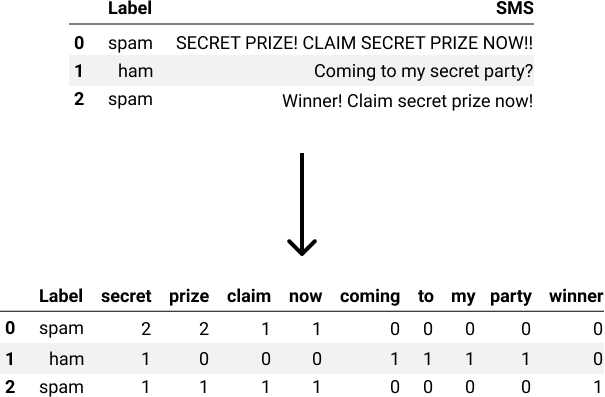

Começaremos removendo as pontuações e fazendo com que todas as letras sejam minúsculas.

In [30]:
# Antes da transformação
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [31]:
# Depois da transformação
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-1637779832.py:2: SyntaxWarning: invalid escape sequence '\W'
  training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')


,Label,SMS
0,ham,"yep, by the pretty sculpture"
1,ham,"yes, princess. are you going to make me moan?"
2,ham,welp apparently he retired
3,ham,havent.
4,ham,i forgot 2 ask ü all smth.. there's a card on ...


# **Criando o Vocabulário**

O vocabulário é uma lista com todas as palavras únicas no nosso dataset de treino.

In [32]:
# Recarrega o conjunto de treinamento para garantir que a coluna 'SMS' seja do tipo string
training_set = data_randomized[:training_test_index].reset_index(drop=True)

# Aplica novamente as etapas de limpeza na ordem correta
training_set['SMS'] = training_set['SMS'].str.replace(r'\W', ' ', regex=True)
training_set['SMS'] = training_set['SMS'].str.lower()

# Separação das palavras
training_set['SMS'] = training_set['SMS'].str.split()

# Criação do vocabulário
vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

# Remove duplicatas e cria a lista final de palavras únicas
vocabulary = list(set(vocabulary))
print(len(vocabulary))

7783


# **Configuração Final**

In [33]:
# Cria um dicionário onde cada palavra única do vocabulário é uma chave
# O valor associado a cada palavra é uma lista de zeros, com tamanho igual ao número de mensagens no conjunto de treino.
# Cada posição da lista representa quantas vezes aquela palavra aparece em uma determinada mensagem.
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1


In [34]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,goigng,07808726822,lifting,recently,flute,sae,15pm,hanks,6th,want,...,vibrator,orange,sk3,aww,08717898035,lovingly,alright,yah,ecstasy,phb1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Concatena o conjunto de treino original com o DataFrame que contém
# as contagens de palavras, lado a lado
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()


,Label,SMS,goigng,07808726822,lifting,recently,flute,sae,15pm,hanks,...,vibrator,orange,sk3,aww,08717898035,lovingly,alright,yah,ecstasy,phb1
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Algoritmo:

In [36]:
# Isolando as mensagens de spam e ham (não spam)
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages  = training_set_clean[training_set_clean['Label'] == 'ham']

# Calculando as probabilidades a priori:
# P(Spam) = probabilidade de uma mensagem ser spam
# P(Ham)  = probabilidade de uma mensagem ser não spam
p_spam = len(spam_messages) / len(training_set_clean)
p_ham  = len(ham_messages) / len(training_set_clean)

# Calculando o total de palavras em todas as mensagens de spam
# (N_Spam = soma do número de palavras por mensagem de spam)
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# Calculando o total de palavras em todas as mensagens de ham
# (N_Ham = soma do número de palavras por mensagem de não spam)
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# Tamanho do vocabulário
n_vocabulary = len(vocabulary)

# Definição do parâmetro de suavização de Laplace (Additive Smoothing)
alpha = 1


Cálculo das Probabilidades Condicionais

Agora que já temos separadas as mensagens de spam e não spam, e calculamos o número total de palavras em cada grupo, o próximo passo é determinar a probabilidade de cada palavra aparecer em uma mensagem de cada tipo.

Para isso, vamos calcular:

- \( $P(w_i|Spam)$ \): probabilidade de a palavra \( w_i \) aparecer em uma mensagem **spam**  
- \( $P(w_i|Ham)$ \): probabilidade de a palavra \( w_i \) aparecer em uma mensagem **não spam**

Essas probabilidades são estimadas a partir das contagens de palavras, aplicando a suavização de Laplace para evitar valores iguais a zero:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{vocabulary}}
$$

O resultado será armazenado em dois dicionários:
- `parameters_spam`: contém as probabilidades de cada palavra dado que a mensagem é spam  
- `parameters_ham`: contém as probabilidades de cada palavra dado que a mensagem é não spam  

Esses valores serão usados mais adiante para calcular as probabilidades de uma nova mensagem pertencer a cada classe.


In [37]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam

    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

# Classificando Uma Mensagem

Aqui vamos utilizar as probabilidades calculadas anteriormente para classificar novas mensagens como *spam* ou *não spam (ham)*.

A função `classify(message)` recebe uma mensagem de texto e executa os seguintes passos:

1. **Limpeza do texto**: remove caracteres não alfanuméricos e converte tudo para letras minúsculas.  
2. **Tokenização**: divide a mensagem em uma lista de palavras.  
3. **Cálculo das probabilidades**:
   - Inicia com as probabilidades a priori \( P(Spam) \) e \( P(Ham) \).
   - Para cada palavra da mensagem, multiplica pelas probabilidades condicionais correspondentes.
4. **Comparação**:
   - Se \( P(Ham|message) > P(Spam|message) \), a mensagem é classificada como **Ham**.
   - Caso contrário, é classificada como **Spam**.


In [38]:
import re

def classify(message):
    '''
    message: string
    '''

    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Probabilidades iguais. Humano, classifique-as')

<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-3018027812.py:8: SyntaxWarning: invalid escape sequence '\W'
  message = re.sub('\W', ' ', message)


In [39]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [40]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


In [41]:
classify("Unlock for free")

P(Spam|message): 6.912086266447539e-06
P(Ham|message): 4.132582429797198e-06
Label: Spam


# Medindo a Acurácia

A partir deste ponto, podemos analisar como o nosso filtro se sai em relação à acurácia com os dados teste (com 1114 mensagens).

In [42]:
def classify_test_set(message):
    '''
    message: string
    '''

    # Remove caracteres não alfanuméricos e transforma a string em lista de palavras
    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    # Inicializa as probabilidades com as probabilidades a priori
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    # Atualiza as probabilidades multiplicando pelos parâmetros de cada palavra
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    # Compara probabilidades e retorna a classificação final
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'precisa de classificação humana'


<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-1050996838.py:7: SyntaxWarning: invalid escape sequence '\W'
  message = re.sub('\W', ' ', message)


POdemos criar uma nova coluna no dataset de teste:

In [43]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Função de medição de acurácia:

In [44]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


A acurácia está próxima de 98,74%, o que é realmente bom. Nosso filtro de spam analisou 1.114 mensagens que ele não havia visto durante o treinamento e classificou corretamente 1.100 delas.